# Planet: Understanding the Amazon from Space

---

Use satellite data to track the human footprint in the Amazon rainforest

In [3]:
import matplotlib.pyplot as plt
from matplotlib.image import imread
%matplotlib inline

import pandas as pd
import numpy as np

In [1]:
import tensorflow as tf

In [5]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

Using TensorFlow backend.


In [19]:
from os import listdir

### 1. Data Visualization

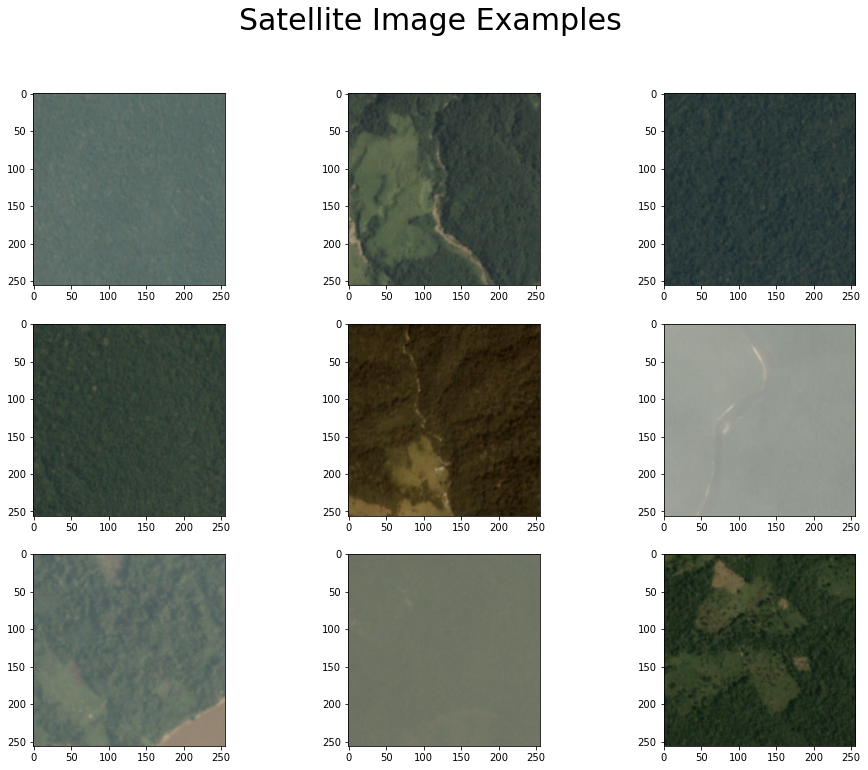

In [6]:
folder = 'train-jpg/'
fig = plt.figure(figsize=(16, 12))
fig.suptitle('Satellite Image Examples', fontsize=30)
# plot 9 images
for i in range(9):
    plt.subplot(330+1+i)
    filename = folder + 'train_' + str(i) + '.jpg'
    image = imread(filename)
    plt.imshow(image)
plt.show()

### 2. Understanding Labels and Create Mappings

In [7]:
mapping_csv = pd.read_csv('train_v2.csv')
print(mapping_csv.shape)
mapping_csv.head(10)

(40479, 2)


,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road
5,train_5,haze primary water
6,train_6,agriculture clear cultivation primary water
7,train_7,haze primary
8,train_8,agriculture clear cultivation primary
9,train_9,agriculture clear cultivation primary road


40,479 training images

### 3. One Hot Encoding 

A vector with all zeros and a one at the index for each tag applied to the image.

In [8]:
labels = set()
for i in range(len(mapping_csv)):
    tags = mapping_csv['tags'][i].split(' ')
    labels.update(tags)

We will order it alphabetically and each tag assigned an integer based on this alphabetic rank.

In [9]:
labels = list(labels)
labels.sort()

In [10]:
print(labels)

['agriculture', 'artisinal_mine', 'bare_ground', 'blooming', 'blow_down', 'clear', 'cloudy', 'conventional_mine', 'cultivation', 'habitation', 'haze', 'partly_cloudy', 'primary', 'road', 'selective_logging', 'slash_burn', 'water']


In [11]:
# dictionary that maps labels to integers and vice versa
labels_map = {labels[i]: i for i in range(len(labels))}
inv_labels_map = {i: labels[i] for i in range(len(labels))}

Adding the steps above to a function create_tag_mapping

In [12]:
def create_tag_mapping(mapping_csv):
    labels = set()
    for i in range(len(mapping_csv)):
        tags = mapping_csv['tags'][i].split(' ')
        labels.update(tags)
    labels = list(labels)
    labels.sort()
    labels_map = {labels[i]: i for i in range(len(labels))}
    inv_labels_map = {i: labels[i] for i in range(len(labels))}
    return labels_map, inv_labels_map

Testing the function now

In [13]:
mapping, inv_mapping = create_tag_mapping(mapping_csv)
print("Number of unique tags {}".format(len(mapping)))
print(" ")
print("Tags are mapped to unique numbers in alphabetical order:")
print(mapping)

Number of unique tags 17
 
Tags are mapped to unique numbers in alphabetical order:
{'agriculture': 0, 'artisinal_mine': 1, 'bare_ground': 2, 'blooming': 3, 'blow_down': 4, 'clear': 5, 'cloudy': 6, 'conventional_mine': 7, 'cultivation': 8, 'habitation': 9, 'haze': 10, 'partly_cloudy': 11, 'primary': 12, 'road': 13, 'selective_logging': 14, 'slash_burn': 15, 'water': 16}


We will also create a dictionary with the filename of the image as the key and the list of tags as the value.

In [14]:
def create_file_mapping(mapping_csv):
    mapping = dict()
    for i in range(len(mapping_csv)):
        name, tags = mapping_csv['image_name'][i], mapping_csv['tags'][i]
        mapping[name] = tags.split(' ')
    return mapping

### 4. Create In-Memory Dataset

In [25]:
def one_hot_encode(tags, mapping):
    encoding = np.zeros(len(mapping), dtype='uint8')
    for tag in tags:
        encoding[mapping[tag]] = 1
    return encoding

Given a list of tags for an image and the mapping of tags to integers as arguments, and it will return a 17 element NumPy array that describes a one hot encoding of the tags for one photo.

We will force the size of the image to be smaller to save memory and speed up training. (256x256 to 128x128). We will also store the pixel values as an unsigned 8-bit integer.

In [23]:
def load_dataset(path, file_mapping, tag_mapping):
    photos, targets = list(), list()
    for filename in listdir(folder):
        photo = load_img(path + filename, target_size=(128,128))
        photo = img_to_array(photo, dtype = 'uint8')
        tags = file_mapping[filename[:-4]]
        target = one_hot_encode(tags, tag_mapping)
        photos.append(photo)
        targets.append(target)
    X = np.asarray(photos, dtype='uint8')
    y = np.asarray(targets, dtype='uint8')
    return X,y

If you run out of memory here, or later when modeling (when pixels are 16 or 32 bits), try reducing the size of the loaded photos to 32×32 and/or stop the loop after loading 20,000 photographs.

In [26]:
tag_mapping, _ = create_tag_mapping(mapping_csv)
file_mapping = create_file_mapping(mapping_csv)
X, y = load_dataset(folder, file_mapping, tag_mapping)
print(X.shape, y.shape)
np.savez_compressed('planet_data.npz', X, y) # Saves both arrays in compressed format

(40479, 128, 128, 3) (40479, 17)
